In [1]:
# SYSTEM IMPORTS
import sys
import os
import collections
import functools
import asyncio
import time
from pathlib import Path
import traceback
from multiprocessing import Pool
from functools import partial
import json
import copy

# MODULE IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import h5py
import sklearn

## Specific module imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from scipy.interpolate import interp1d, UnivariateSpline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, auc, roc_curve
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.autonotebook import tqdm

## FastAI and Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import fastai
from fastai.basic_train import *
from fastai.train import *
from fastai.metrics import *
from fastai.callbacks import *
from fastai import core, data_block
from fastai.distributed import *

from TCN.TCN.tcn import TemporalConvNet, TCN_DimensionalityReduced, TemporalSkipBlock

from utils import *

c:\users\chris\.virtualenvs\sepsis-ml-mltipoic\lib\site-packages\ipykernel_launcher.py:33: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# pretty display stuff
from IPython.display import display, clear_output

In [3]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [4]:
datab = fastai.basic_train.load_data(
    'D:/training_cov_npy/',
    'datab.pkl',
    collate_fn=pad_collate,
    pin_memory=False,
    num_workers=1,
    bs=2048
)

In [5]:
# results = []
classification_reports = []
skf = StratifiedKFold(10, random_state=42, shuffle=False)
model_outputs = []
for idx, (train_idx, test_idx) in enumerate(tqdm(skf.split(range(len(datab.test_ds.x)), np.any(datab.test_ds.y.items, axis=1).astype('int')), total=10)):
    split_ils = datab.test_ds.x.split_by_idxs(train_idx, test_idx)
    split_ils_y = datab.test_ds.y.split_by_idxs(train_idx, test_idx)
    x_train, x_valid, y_train, y_valid = split_ils.train, split_ils.valid, \
        split_ils_y.train, split_ils_y.valid
    ll = fastai.data_block.LabelLists(
        datab.path,
        train=data_block.LabelList(x_train, y_train, tfms=[]),
        valid=data_block.LabelList(x_valid, y_valid, tfms=[]),
    )
    ll.test = datab.test_ds
#     print("Loading Database", end='\t')
    datab = ll.transform([]).databunch(
        collate_fn=pad_collate,
        num_workers=0,
        pin_memory=True,
        bs=2048
    )
#     print("Done")
    net = TCN(
        40,
        336,
        [32] * 3,
        64,
#         [32] * 9,
#         2,
        0.2,
        use_skip_connections=True,
        reduce_dimensionality=False
    )
    net.load_state_dict(torch.load('prototyping/10fold-100/ProtoTCN-%d_fold-best.pth' % (idx+1))['model'])
    preds, y, losses = get_preds(net.cuda(), datab.valid_dl, loss_func=nn.BCEWithLogitsLoss())
    sigmoid = nn.Sigmoid()(preds)
#     print(preds.shape, sigmoid.shape)
    thresh = 0.5
#     results.append(
#         get_normalised_utility_score(
#             y.numpy()[:, 250:],
#             (sigmoid.numpy() > thresh).astype('int')[:, 250:],
#             sigmoid.numpy()[:, 250:]
#         )
#     )
    classification_reports.append(
        classification_report(
            np.any(y.numpy()[:, 250:], axis=1),
            np.any((sigmoid.numpy() > thresh)[:, 250:], axis=1),
            labels=[False, True],
            output_dict=True
        )
    )
    model_outputs.append({
        'preds': preds,
        'y': y,
        'sigmoid': sigmoid,
        'test_indices': test_idx
    })
#     clear_output(wait=True)
#     results_df = pd.DataFrame(results, columns=["auroc", "auprc", "accuracy", "f_measure", "normalized_observed_utility"])
#     display(results_df)

c:\users\chris\.virtualenvs\sepsis-ml-mltipoic\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


c:\users\chris\.virtualenvs\sepsis-ml-mltipoic\lib\site-packages\torch\cuda\__init__.py:132: UserWarning: 
    Found GPU0 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [5]:
for report in classification_reports:
    display(pd.DataFrame(report))

,False,True,accuracy,macro avg,weighted avg
precision,0.987754,0.273899,0.823004,0.630826,0.935905
recall,0.819300,0.870307,0.823004,0.844803,0.823004
f1-score,0.895675,0.416667,0.823004,0.656171,0.860883
support,3741.000000,293.000000,0.823004,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.987909,0.211948,0.752851,0.599928,0.931549
recall,0.742582,0.883959,0.752851,0.813271,0.752851
f1-score,0.847856,0.341914,0.752851,0.594885,0.811108
support,3741.000000,293.000000,0.752851,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.979555,0.317797,0.863411,0.648676,0.931490
recall,0.870890,0.767918,0.863411,0.819404,0.863411
f1-score,0.922032,0.449550,0.863411,0.685791,0.887714
support,3741.000000,293.000000,0.863411,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.983007,0.247433,0.805404,0.615220,0.929580
recall,0.804063,0.822526,0.805404,0.813294,0.805404
f1-score,0.884576,0.380426,0.805404,0.632501,0.847958
support,3741.000000,293.000000,0.805404,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.984268,0.223423,0.774913,0.603846,0.928817
recall,0.769519,0.843537,0.774913,0.806528,0.774913
f1-score,0.863745,0.353276,0.774913,0.608511,0.826542
support,3740.000000,294.000000,0.774913,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.987836,0.197578,0.729053,0.592707,0.930242
recall,0.716578,0.887755,0.729053,0.802166,0.729053
f1-score,0.830621,0.323220,0.729053,0.576921,0.793642
support,3740.000000,294.000000,0.729053,4034.000000,4034.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.985737,0.262658,0.81577,0.624198,0.933205
recall,0.813102,0.849829,0.81577,0.831465,0.815770
f1-score,0.891136,0.401289,0.81577,0.646212,0.855548
support,3740.000000,293.000000,0.81577,4033.000000,4033.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.987697,0.232159,0.780312,0.609928,0.932806
recall,0.772727,0.877133,0.780312,0.824930,0.780312
f1-score,0.867087,0.367143,0.780312,0.617115,0.830765
support,3740.000000,293.000000,0.780312,4033.000000,4033.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.984402,0.216028,0.765683,0.600215,0.928579
recall,0.759358,0.846416,0.765683,0.802887,0.765683
f1-score,0.857358,0.344205,0.765683,0.600782,0.820078
support,3740.000000,293.000000,0.765683,4033.000000,4033.000000


,False,True,accuracy,macro avg,weighted avg
precision,0.986561,0.224580,0.772874,0.605571,0.931203
recall,0.765508,0.866894,0.772874,0.816201,0.772874
f1-score,0.862090,0.356742,0.772874,0.609416,0.825376
support,3740.000000,293.000000,0.772874,4033.000000,4033.000000


In [6]:
report_dfs = [pd.DataFrame(report) for report in classification_reports]
report_dfs_np = np.array([report.to_numpy() for report in report_dfs])
report_mean, report_std = report_dfs_np.mean(axis=0), report_dfs_np.std(axis=0)

In [7]:
report_df = pd.concat(report_dfs, join='inner') \
.rename_axis('score_type') \
.reset_index() \
.groupby('score_type') \
.agg(['mean', lambda x: 1.96 * x.std() / np.sqrt(len(x))]) \
.rename(columns={'<lambda_0>': '95% CI'})
report_df.loc[:'recall'] = report_df.loc[:'recall'] * 100

In [8]:
report_df

False                  True             accuracy            \
                   mean    95% CI        mean    95% CI       mean    95% CI   
score_type                                                                     
f1-score      97.584113  0.124108   64.684894  1.916064  95.477948  0.231794   
precision     96.696282  0.181306   74.933043  2.586953  95.477948  0.231794   
recall        98.489450  0.203041   57.060667  2.444791  95.477948  0.231794   
support     3740.400000  0.320067  293.200000  0.261333   0.954779  0.002318   

              macro avg           weighted avg            
                   mean    95% CI         mean    95% CI  
score_type                                                
f1-score      81.134503  1.014458    95.192663  0.248255  
precision     85.814662  1.307627    95.114390  0.267031  
recall        77.775059  1.206390    95.477948  0.231794  
support     4033.600000  0.320067  4033.600000  0.320067

In [9]:
model_outputs_cropped = copy.deepcopy(model_outputs)
for idx, fold in enumerate(tqdm(model_outputs_cropped)):
    test_indices = fold['test_indices']
    data_lengths = [datab.test_ds.x[index].len for index in test_indices]
    model_outputs_cropped[idx]['data_lengths'] = data_lengths

In [10]:
model_outputs_cropped_b = copy.deepcopy(model_outputs_cropped)

In [11]:
results_cropped = []
results_df_cropped = None
for idx, fold in enumerate(tqdm(model_outputs_cropped)):
    y_cropped, preds_cropped, sigmoids_cropped, binary_labels_cropped = [], [], [], []
    y_flat, preds_flat, sigmoid_flat = [], [], []
    for sample_idx, length in enumerate(fold['data_lengths']):
        y_cropped.append(model_outputs_cropped[idx]['y'][sample_idx][-length:].numpy())
        preds_cropped.append(model_outputs_cropped[idx]['preds'][sample_idx][-length:].numpy())
        sigmoids_cropped.append(model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:].numpy())
        binary_labels_cropped.append(
            np.array(model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:] > thresh).astype('int')
        )
        
        y_flat += model_outputs_cropped[idx]['y'][sample_idx][-length:]
        preds_flat += model_outputs_cropped[idx]['preds'][sample_idx][-length:]
        sigmoid_flat += model_outputs_cropped[idx]['sigmoid'][sample_idx][-length:]
    model_outputs_cropped[idx]['y_cropped'] = y_cropped
    model_outputs_cropped[idx]['preds_cropped'] = preds_cropped
    model_outputs_cropped[idx]['sigmoid_cropped'] = sigmoids_cropped
    
    model_outputs_cropped[idx]['y_flat'] = np.array(y_flat)
    model_outputs_cropped[idx]['preds_flat'] = np.array(preds_flat)
    model_outputs_cropped[idx]['sigmoid_flat'] = np.array(sigmoid_flat)
    
    results_cropped.append(
        get_normalised_utility_score(
            y_cropped,
            binary_labels_cropped,
            sigmoids_cropped
        )
    )
    clear_output(wait=True)
    results_df_cropped = pd.DataFrame(results_cropped, columns=["auroc", "auprc", "accuracy", "f_measure", "normalized_observed_utility"])
    display(results_df_cropped)

,auroc,auprc,accuracy,f_measure,normalized_observed_utility
0,0.975632,0.679900,0.989056,0.634784,0.466054
1,0.972095,0.638717,0.988495,0.589425,0.403484
2,0.980319,0.717838,0.989815,0.660795,0.482188
3,0.976039,0.702525,0.989693,0.648910,0.464069
4,0.970896,0.653896,0.988801,0.596091,0.399787
5,0.981805,0.679423,0.988107,0.617745,0.466147
6,0.977388,0.623712,0.987482,0.570098,0.409193
7,0.975370,0.629796,0.988277,0.602446,0.431514
8,0.977707,0.574613,0.987098,0.545660,0.385086
9,0.981771,0.615706,0.987417,0.559116,0.394531


In [13]:
results_df_cropped.describe()

,auroc,auprc,accuracy,f_measure,normalized_observed_utility
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.976902,0.651613,0.988424,0.602507,0.430205
std,0.003715,0.043711,0.000935,0.038300,0.036235
min,0.970896,0.574613,0.987098,0.545660,0.385086
25%,0.975436,0.625233,0.987638,0.574930,0.400711
50%,0.976714,0.646307,0.988386,0.599269,0.420354
75%,0.979666,0.679780,0.988992,0.630525,0.465557
max,0.981805,0.717838,0.989815,0.660795,0.482188


In [243]:
datab.valid_ds.x[9].data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [14.5000, 14.5000, 14.5000,  ..., 14.5000, 14.5000, 14.5000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-5.9300, -5.9300, -5.9300,  ..., -5.9300, -5.9300, -5.9300],
        [ 1.0000,  2.0000,  3.0000,  ..., 28.0000, 29.0000, 30.0000]],
       dtype=torch.float64)

In [14]:
from sklearn.metrics import classification_report, auc, precision_recall_curve
from sklearn.metrics import roc_curve as sk_roc_curve
from scipy import interp
sns.set()
plt.style.use('seaborn-paper')

c:\users\chris\.virtualenvs\sepsis-ml-mltipoic\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


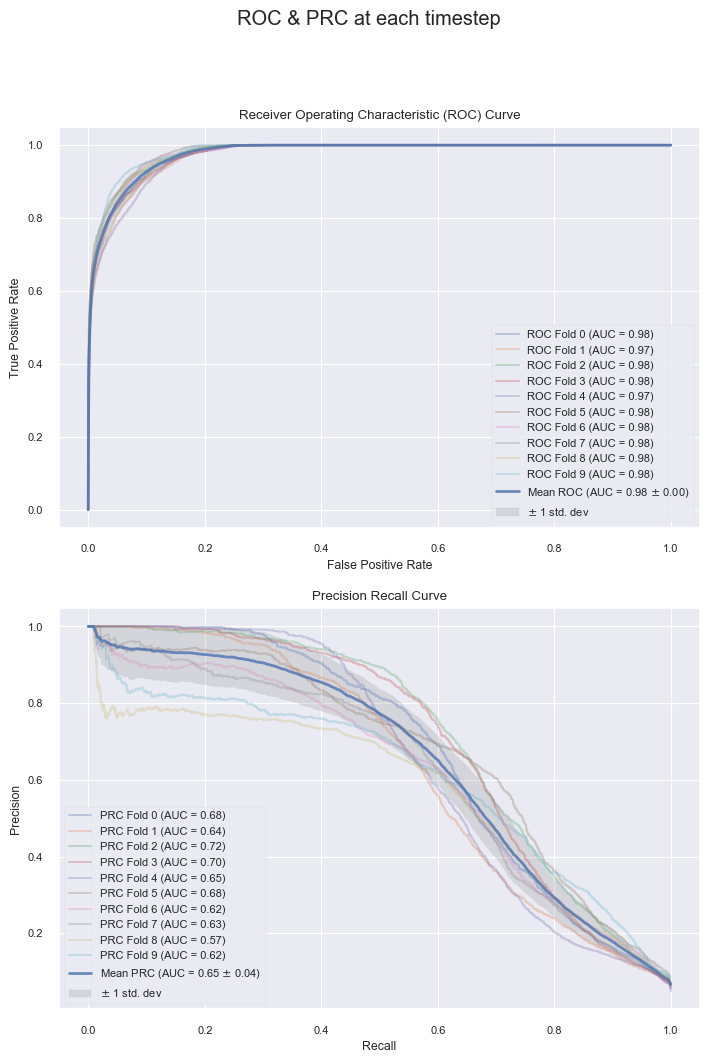

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=100)
tprs, aurocs = [], []
tpr_threshes = []
fpr_mean = np.linspace(0, 1, 1000)
precisions, auprcs = [], []
recall_threshes = []
recall_mean = np.linspace(0, 1, 1000)
for fold_idx, fold in enumerate(tqdm(model_outputs_cropped)):
    # ROC
    fpr, tpr, tpr_thresh = sk_roc_curve(fold['y_flat'], fold['sigmoid_flat'])
    tpr_threshes.append(tpr_thresh[np.abs(tpr-0.85).argmin()])
    tpr_interp = np.interp(fpr_mean, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aurocs.append(auc(fpr, tpr))
    ax[0].plot(fpr, tpr, label="ROC Fold %d (AUC = %0.2f)" % (fold_idx, aurocs[fold_idx]), alpha=.3)
    # PRC
    precision, recall, prc_thresh = precision_recall_curve(fold['y_flat'], fold['sigmoid_flat'])
    prec_interp = np.interp(recall_mean, recall[::-1], precision[::-1])
#     prec_interp[0] = 1.0
    precisions.append(prec_interp)
    recall_threshes.append(prc_thresh[np.abs(recall-0.85).argmin()])
    auprcs.append(auc(recall, precision))
    ax[1].plot(recall, precision, label="PRC Fold %d (AUC = %0.2f)" % (fold_idx, auprcs[fold_idx]), alpha=.3)

ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Receiver Operating Characteristic (ROC) Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision Recall Curve")

# ROC
tpr_mean = np.mean(tprs, axis=0)
tpr_mean[-1] = 1.0
auroc_mean = auc(fpr_mean, tpr_mean)
auroc_std  = np.std(aurocs)
ax[0].plot(fpr_mean, tpr_mean,
           label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (auroc_mean, auroc_std),
           lw=2, alpha=.8)
tpr_std = np.std(tprs, axis=0)
ax[0].fill_between(
    fpr_mean,
    np.maximum(tpr_mean+tpr_std, 0),
    np.minimum(tpr_mean-tpr_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)
# PRC
prec_mean = np.mean(precisions, axis=0)
# prec_mean[-1] = 0.0
auprc_mean = auc(recall_mean, prec_mean)
auprc_std = np.std(auprcs)
ax[1].plot(recall_mean, prec_mean,
           label=r"Mean PRC (AUC = %0.2f $\pm$ %0.2f)" % (auprc_mean, auprc_std),
           lw=2, alpha=.8)
prec_std = np.std(precisions, axis=0)
ax[1].fill_between(
    recall_mean,
    np.maximum(prec_mean-prec_std, 0),
    np.minimum(prec_mean+prec_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)

fig.suptitle("ROC & PRC at each timestep")
ax[0].legend()
ax[1].legend()
plt.show()

In [42]:
tpr_threshes, recall_threshes

([0.059137672,
  0.044070657,
  0.056783326,
  0.04249861,
  0.032578297,
  0.048405938,
  0.036267117,
  0.041176565,
  0.049825583,
  0.05612391],
 [0.05895731,
  0.04390825,
  0.05677564,
  0.042456448,
  0.032510582,
  0.04832947,
  0.03624176,
  0.04096476,
  0.04952772,
  0.056114133])

In [28]:
for (idx, tpr) in enumerate(tprs):
    i = np.abs(tpr - 0.85).argmin()
    tprs[idx][i]

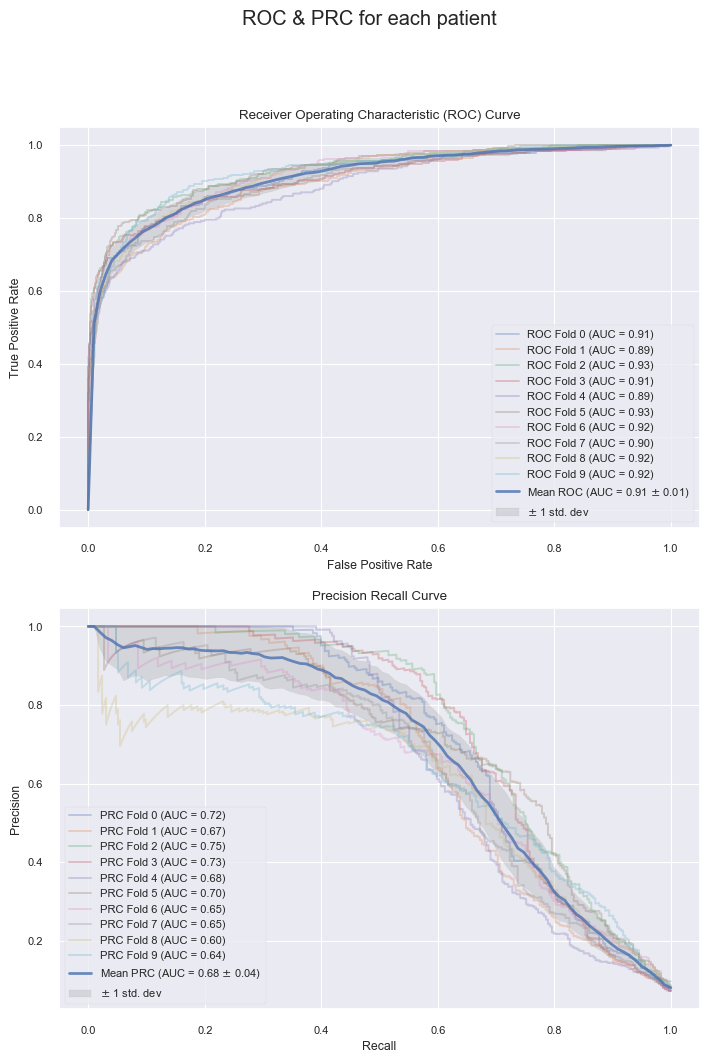

In [43]:
fig2, ax2 = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=100)
tprs, aurocs = [], []
tpr_threshes = []
fpr_mean = np.linspace(0, 1, 100)
precisions, auprcs = [], []
recall_threshes = []
recall_mean = np.linspace(0, 1, 100)
for fold_idx, fold in enumerate(tqdm(model_outputs_cropped)):
    # ROC
    fpr, tpr, roc_threshes = sk_roc_curve(
        [np.any(label).astype('int') for label in fold['y_cropped']],
        [np.max(sigmoid) for sigmoid in fold['sigmoid_cropped']]
    )
    tpr_interp = np.interp(fpr_mean, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aurocs.append(auc(fpr, tpr))
    tpr_threshes.append(roc_threshes[np.abs(tpr - 0.85).argmin()])
    ax2[0].plot(fpr, tpr, label="ROC Fold %d (AUC = %0.2f)" % (fold_idx, aurocs[fold_idx]), alpha=.3)
    # PRC
    precision, recall, prc_threshes = precision_recall_curve(
        [np.any(label).astype('int') for label in fold['y_cropped']],
        [np.max(sigmoid) for sigmoid in fold['sigmoid_cropped']]
    )
    prec_interp = np.interp(recall_mean, recall[::-1], precision[::-1])
#     prec_interp[0] = 1.0
    precisions.append(prec_interp)
    auprcs.append(auc(recall, precision))
    recall_threshes.append(prc_threshes[np.abs(recall - 0.85).argmin()])
    ax2[1].plot(recall, precision, label="PRC Fold %d (AUC = %0.2f)" % (fold_idx, auprcs[fold_idx]), alpha=.3)

ax2[0].set_xlabel("False Positive Rate")
ax2[0].set_ylabel("True Positive Rate")
ax2[0].set_title("Receiver Operating Characteristic (ROC) Curve")
ax2[1].set_xlabel("Recall")
ax2[1].set_ylabel("Precision")
ax2[1].set_title("Precision Recall Curve")
# ROC
tpr_mean = np.mean(tprs, axis=0)
tpr_mean[-1] = 1.0
auroc_mean = auc(fpr_mean, tpr_mean)
auroc_std  = np.std(aurocs)
ax2[0].plot(fpr_mean, tpr_mean,
           label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (auroc_mean, auroc_std),
           lw=2, alpha=.8)
tpr_std = np.std(tprs, axis=0)
ax2[0].fill_between(
    fpr_mean,
    np.maximum(tpr_mean+tpr_std, 0),
    np.minimum(tpr_mean-tpr_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)
# PRC
prec_mean = np.mean(precisions, axis=0)
# prec_mean[-1] = 0.0
auprc_mean = auc(recall_mean, prec_mean)
auprc_std = np.std(auprcs)
ax2[1].plot(recall_mean, prec_mean,
           label=r"Mean PRC (AUC = %0.2f $\pm$ %0.2f)" % (auprc_mean, auprc_std),
           lw=2, alpha=.8)
prec_std = np.std(precisions, axis=0)
ax2[1].fill_between(
    recall_mean,
    np.maximum(prec_mean-prec_std, 0),
    np.minimum(prec_mean+prec_std, 1),
    alpha=.2,
    label=r"$\pm$ 1 std. dev",
    color='grey'
)

fig2.suptitle("ROC & PRC for each patient")
ax2[0].legend()
ax2[1].legend()
plt.show()

In [48]:
_85sens_threshes = np.mean(list(zip(tpr_threshes, recall_threshes)), axis=1)

In [54]:
_85sens_classification_reports = []
for fold_idx, fold in enumerate(tqdm(model_outputs_cropped)):
    _85sens_classification_reports.append(classification_report(
        [np.any(y) for y in fold['y_cropped']],
        [np.any(sigmoid > _85sens_threshes[fold_idx]) for sigmoid in fold['sigmoid_cropped']],
        labels=[False, True],
        output_dict=True
    ))

In [55]:
_85sens_report_dfs = [pd.DataFrame(report) for report in _85sens_classification_reports]
_85sens_report_dfs_np = np.array([report.to_numpy() for report in _85sens_report_dfs])
_85sens_report_mean, _85sens_report_std = _85sens_report_dfs_np.mean(axis=0), _85sens_report_dfs_np.std(axis=0)

In [58]:
_85sens_report_df = pd.concat(_85sens_report_dfs, join='inner') \
.rename_axis('score_type') \
.reset_index() \
.groupby('score_type') \
.agg(['mean', lambda x: 1.96 * x.std() / np.sqrt(len(x))]) \
.rename(columns={'<lambda_0>': '95% CI'})
_85sens_report_df.loc[:'recall'] = _85sens_report_df.loc[:'recall'] * 100

In [59]:
_85sens_report_df

False                  True             accuracy            \
                   mean    95% CI        mean    95% CI       mean    95% CI   
score_type                                                                     
f1-score      87.974541  2.169837   38.979675  3.512049  80.000642  3.157512   
precision     98.537361  0.066077   25.473816  2.946557  80.000642  3.157512   
recall        79.609090  3.405884   84.993151  0.013349  80.000642  3.157512   
support     3740.400000  0.320067  293.200000  0.261333   0.800006  0.031575   

              macro avg           weighted avg            
                   mean    95% CI         mean    95% CI  
score_type                                                
f1-score      63.477108  2.825254    84.413111  2.263326  
precision     62.005588  1.504773    93.226305  0.274731  
recall        82.301120  1.700405    80.000642  3.157512  
support     4033.600000  0.320067  4033.600000  0.320067

In [276]:
bce_weights = []
for fold in tqdm(model_outputs):
    bce_weights.append(fold['y'].numpy())
bce_weights = np.concatenate(bce_weights, axis=0)
n = len(bce_weights)
bce_weights = n/np.sum(bce_weights, axis=0)
bce_weights[bce_weights==np.inf] = n
bce_weights[-10:]

c:\users\chris\.virtualenvs\sepsis-ml-mltipoic\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


array([21.570053, 15.13546 , 13.846893, 13.827906, 13.804244, 13.804244, 13.794802, 13.794802, 13.780663, 13.757162],
      dtype=float32)